In [18]:
import cv2
import math
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from IPython.display import display, HTML

%matplotlib inline

In [19]:
image = cv2.imread("demo/img/demo2.png")

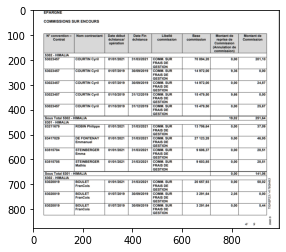

In [20]:
plt.imshow(image)
plt.rcParams['figure.figsize'] = [60, 60]
plt.show()
plt.rcParams['figure.figsize'] = [10, 10]

In [21]:
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
data = pytesseract.image_to_data(rgb, output_type=Output.DICT)

In [22]:
# Create the data List

results = []

for idx, i in enumerate(data['text']):
    if not i == '' \
    and not i == '|' \
    and not i == ' ':
    #and not 3 * data['width'][idx] < data['height'][idx]:
        results.append({
            'x': (2 * data['left'][idx] + data['width'][idx]) // 2,
            'y': (2 * data['top'][idx] + data['height'][idx]) // 2,
            'xMin': data['left'][idx],
            'yMin': data['top'][idx],
            'xMax': data['left'][idx] + data['width'][idx],
            'yMax': data['top'][idx] + data['height'][idx],
            'text': i
        })

In [23]:
def countOverlappingClusters(clusters, classification, ranges):
    rv = 0
    for cdx, c in enumerate(clusters):
        for rdx, r in enumerate(ranges):
            if c[0] >= r[0] and c[0] <= r[1] and not classification[rdx] == cdx:
                rv += 1
    return rv

def findAB(x1, y1, x2, y2):
    a = (y2-y1) / (x2 - x1)
    b = y1 - ( x1 * (y2-y1) / (x2 - x1))
    return (a, b)

def findSpot(ax, ay):
    rv = []
    for n in range (1, len(ax)-1):
        (a1, b1) = findAB(ax[0], ay[0], ax[n], ay[n]) 
        (a2, b2) = findAB(ax[n], ay[n], ax[-1], ay[-1])
        total = 0
        for idx in range(0, n):
            total += (a1*ax[idx] + b1) - ay[idx]
        for idx in range(n, len(ay)):
            total += (a2*ax[idx] + b2) - ay[idx]
        rv.append((n, total))
        
    rv.sort(key=lambda x: x[1])
    
    return ax[rv[0][0]]
            

In [24]:
X = np.array([[elem['x']] for elem in results])
ranges = [(a['xMin'], a['xMax']) for a in results]

ax = []
ay = []

for n in range(2, len(results)):
    
    kmeans = KMeans(n_clusters=n, random_state=42).fit(X)
    clusters = kmeans.cluster_centers_
    classificaction = kmeans.labels_
    
    o = countOverlappingClusters(clusters, classificaction, ranges)
    ax.append(n)
    ay.append(o)
    if o > 25:
        break

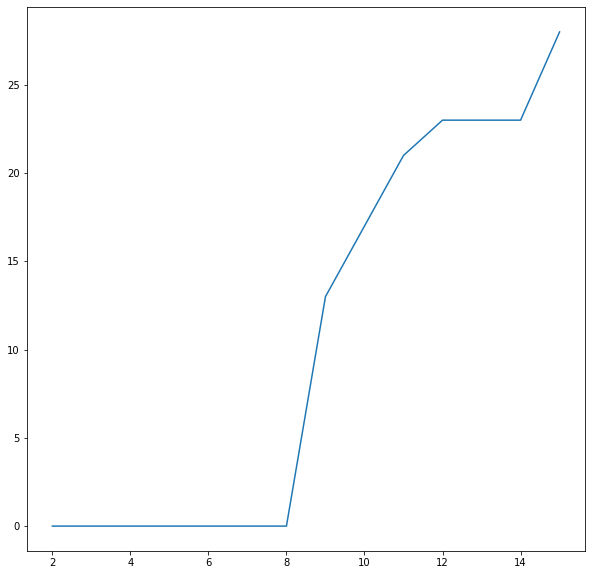

In [25]:
plt.plot(ax, ay, label='overlapping count')

In [26]:
nCols = findSpot(ax, ay)
nCols

8

In [27]:
X = np.array([[elem['y']] for elem in results])
ranges = [(a['yMin'], a['yMax']) for a in results]

ax = []
ay = []

for n in range(2, len(results)):
    
    kmeans = KMeans(n_clusters=n, random_state=42).fit(X)
    clusters = kmeans.cluster_centers_
    classificaction = kmeans.labels_
    
    o = countOverlappingClusters(clusters, classificaction, ranges)
    ax.append(n)
    ay.append(o)
    if o > 25:
        break

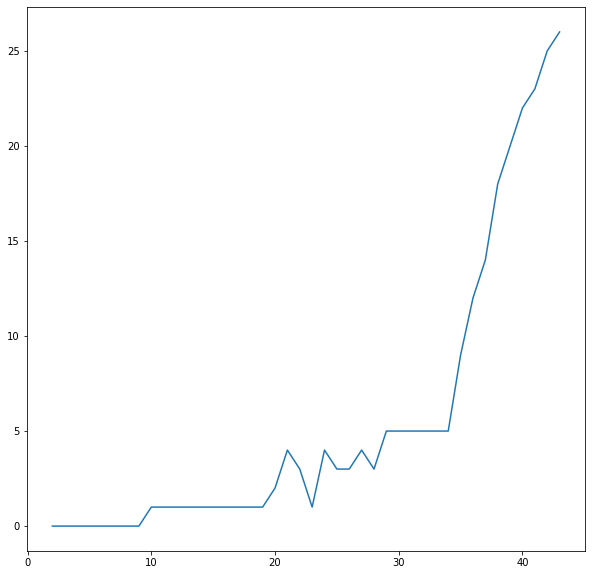

In [28]:
plt.plot(ax, ay, label='overlapping count')

In [29]:
nRows = findSpot(ax, ay)
nRows

34

In [30]:
# Generate the empty result array
array = [['' for _ in range(nCols)] for _ in range(nRows)]

In [31]:
X = np.array([[elem['x']] for elem in results])
kmeans = KMeans(n_clusters=nCols, random_state=42).fit(X)
cols = [(i[0], idx) for idx, i in enumerate(kmeans.cluster_centers_)]
cols.sort(key=lambda x:x[0])
xOrder = [x[1] for x in cols]
for idx, i in enumerate(results):
    results[idx]["xLabel"] = kmeans.labels_[idx]

X = np.array([[elem['y']] for elem in results])
kmeans = KMeans(n_clusters=nRows, random_state=42).fit(X)
rows = [(i[0], idx) for idx, i in enumerate(kmeans.cluster_centers_)]
rows.sort(key=lambda x:x[0])
yOrder = [x[1] for x in rows]
for idx, i in enumerate(results):
    results[idx]["yLabel"] = kmeans.labels_[idx]

In [32]:
# Filling the result array
for idx, i in enumerate(yOrder):
    for jdx, j in enumerate(xOrder):
        t = " ".join([k["text"] for k in results if k["xLabel"] == j and k["yLabel"] == i])
        array[idx][jdx] = t

In [33]:
array

[['EPARGNE', '', '', '', '', '', '', ''],
 ['COMMISSIONS', 'SUR ENCOURS', '', '', '', '', '', ''],
 ['WN’ convention—',
  'Nom contractant',
  'Date début',
  'Date Fin',
  'Tibellé',
  'Base',
  '',
  'Montant de'],
 ['Contrat',
  '',
  '€chéancel',
  'échéance',
  'commission',
  'commission',
  '',
  '‘Commission'],
 ['', '', 'opération', '', '', '', '(Annulation de commission)', ''],
 ["'5302 - HIMALIA", '', '', '', '', '', '', ''],
 ['‘53023457',
  'COURTIN Cyril',
  '01/01/2021',
  '31/03/2021',
  '[COMM. SUR',
  '70 894,20',
  '0,00',
  '201,10'],
 ['', '', '', '', 'FRAIS DE GESTION', '', '', ''],
 ['‘53023457',
  'COURTIN Cyril',
  '01/07/2019',
  '~ 30/09/2019',
  '[COMM. SUR FRAIS DE',
  '14 972,00',
  '9,36',
  '0,00'],
 ['53023457',
  'COURTIN Cyril',
  '01/07/2019',
  '30/09/2019',
  'GESTION [COMM. SUR',
  '14 972,00',
  '0,00',
  '24,87'],
 ['', '', '', '', 'FRAIS DE GESTION', '', '', ''],
 ['53023457',
  'COURTIN Cyril',
  '01/10/2019',
  '31/12/2019',
  '[COMM. SUR',
 

In [34]:
resultDf = pd.DataFrame(np.array(array))
resultDf.to_csv("result1.csv", index=False, sep=',', encoding='utf-8')